In [1]:
%load_ext autoreload
%autoreload 1
%autosave 60

Autosaving every 60 seconds


In [207]:
import sys
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt
from scipy import stats
import scanpy
from anndata import AnnData
import umap
from matplotlib.colors import LogNorm
from anndata import AnnData
from anndata import concat
import json

In [3]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 110
plt.rcParams['font.size'] = 6

In [4]:
sys.path.append("/u/davidm/Documents/Master-thesis/Scripts/RNA-seq/python/")

In [5]:
import rnaseq
importlib.reload(rnaseq)

<module 'rnaseq' from '/u/davidm/Documents/Master-thesis/Scripts/RNA-seq/python/rnaseq/__init__.py'>

In [9]:
project = "dsp779"
sample = "Sample_N701_-_Not_Transfected"
genref = "human/assembly__GRCh38-hg38/annotation__gencode/gencode_34"
annot_path = f"/home/arion/davidm/Data/references/{genref}"

In [259]:
%%bash
tar czf ./figs.tar.gz ./figs/*.pdf

### Knee default alevin

In [204]:
quant_params_default = "trimmed-reads-cutadapt-all/decoys-k19-1.4.0/default"

Sample_N701_-_Not_Transfected 900 782
Sample_N702_-_CTR1 406 276
Sample_N705_-_ER1 91 68
Sample_N707_-_ER2 149 115


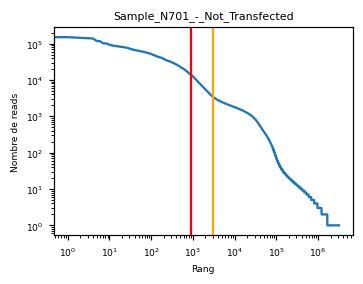

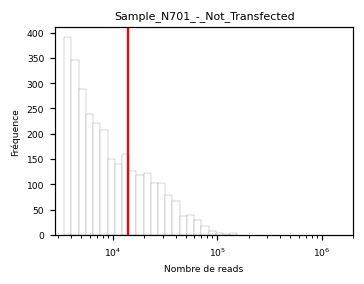

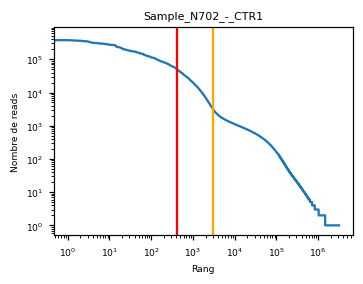

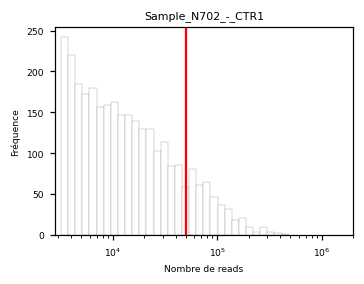

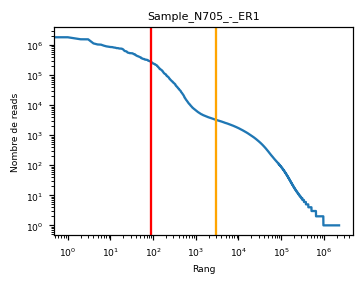

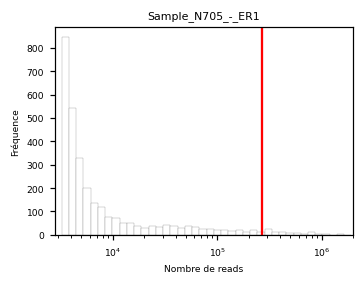

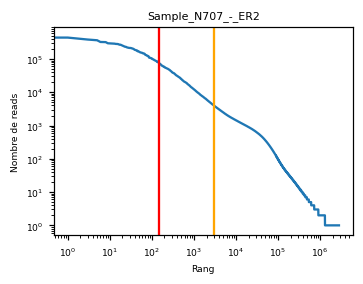

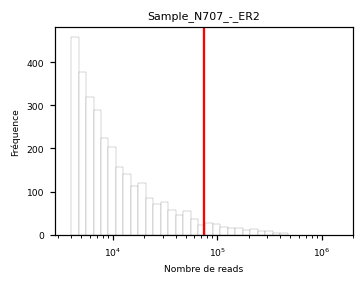

In [249]:
samples = ["Sample_N701_-_Not_Transfected","Sample_N702_-_CTR1","Sample_N705_-_ER1","Sample_N707_-_ER2"]

for sample, bins in zip(samples, [24,32,40,29]):

    f = pd.read_csv(f"/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779/quant/alevin/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/{quant_params_default}/{sample}/alevin/raw_cb_frequency.txt", delimiter='\t', header = None)
    with open(f"/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779/quant/alevin/{genref}/{quant_params_default}/{sample}/aux_info/alevin_meta_info.json") as file:
        data = json.load(file)
    k = data["initial_whitelist"]
    w = data["final_num_cbs"]
    print(sample, k,w)
               
    plt.subplots(figsize=(3.5,2.5))
    plt.plot(f[1].values[f[1].values>0])
    plt.yscale("log");
    plt.xscale("log");
    plt.axvline(3000, color="orange")
    plt.axvline(k, color='red')
    plt.title(sample)
    plt.xlabel("Rang")
    plt.ylabel("Nombre de reads")
    plt.savefig(f"./figs/{sample}_knee-rank.pdf")
               
    _,ax = plt.subplots(figsize=(3.5,2.5))
    plt.axvline(f[1][k], color='red')
    rnaseq.plotting.loghist(f[1].values[:3000], bins=bins, ax=ax, linewidth=0.1, edgecolor='black', color="white");
    plt.title(sample)
    plt.xlim(2800,2e6)
    plt.ylabel("Fréquence")
    plt.xlabel("Nombre de reads")
    plt.savefig(f"./figs/{sample}_knee-dist.pdf");           
    

### Compare k-mers using untrimmed reads

In [202]:
kmers = ["17","19","23","27","29","31"]

In [204]:
mapping_rates = []

for k in kmers :
    sc = rnaseq.readwrite.read_raw(project_id  = project, quant_tool = "alevin", samples = "Sample_N701_-_Not_Transfected", genes_id = "ensembl_gene_id", quant_params = f"raw-reads/decoys-k{k}-1.4.0/forceCells-3000", genref = genref, cdna = "3' tag", exp = "sc")
    sc._inplace_subset_obs(np.argsort(sc.obs["NumGenesExpressed"].values)[::-1][:500])
    mapping_rates.append(sc.obs["MappingRate"].values)

/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779/quant/alevin/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/raw-reads/decoys-k17-1.4.0/forceCells-3000
Using BioMart Ensembl Genes 100 hsapiens_gene_ensembl for gene annotations.
/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779/quant/alevin/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/raw-reads/decoys-k19-1.4.0/forceCells-3000
Using BioMart Ensembl Genes 100 hsapiens_gene_ensembl for gene annotations.
/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779/quant/alevin/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/raw-reads/decoys-k23-1.4.0/forceCells-3000
Using BioMart Ensembl Genes 100 hsapiens_gene_ensembl for gene annotations.
/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779/quant/alevin/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/raw-reads/decoys-k27-1.4.0/forceCells-3000
Using BioMart Ensembl Genes 100 hsapiens_gene_ensembl for ge

In [205]:
[np.mean(m) for m in mapping_rates]

[0.667184268,
 0.6673018580000001,
 0.667074598,
 0.664183484,
 0.6615238379999999,
 0.658072498]

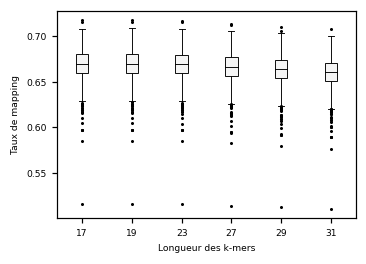

In [206]:
plt.subplots(figsize = (3.5,2.5))
# plt.boxplot(mapping_rates, labels=kmers)
plt.boxplot(mapping_rates, labels=kmers, widths = 0.25, patch_artist = True,\
                 boxprops={'facecolor': 'whitesmoke', 'color' : 'black', 'linewidth': 0.6},\
                 whiskerprops = {'linewidth': 0.6, 'color':'black'},\
                 capprops = {'linewidth': 0.6, 'color':'black'},\
                 medianprops = {'color' : 'black', 'linewidth' : 0.6},\
                 flierprops = {'marker':'.', 'markersize':2,'markerfacecolor':'black', 'markeredgecolor':'black'})
plt.xlabel("Longueur des k-mers")
plt.ylabel("Taux de mapping");
# plt.savefig("./figs/kmers.pdf")

### Compare k-mers using trimmed reads

In [311]:
kmers = ["17","19","23","27","29","31"]

In [318]:
mapping_rates = []

for k in kmers :
    sc = rnaseq.readwrite.read_raw(project_id  = project, quant_tool = "alevin", samples = "Sample_N701_-_Not_Transfected", genes_id = "ensembl_gene_id", quant_params = f"trimmed-reads-cutadapt-all/decoys-k{k}-1.4.0/forceCells-3000", genref = genref, cdna = "3' tag", exp = "sc")
    sc._inplace_subset_obs(np.argsort(sc.obs["raw_cb_freq"].values)[::-1][:300])
    mapping_rates.append(sc.obs["MappingRate"].values)

/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779/quant/alevin/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/trimmed-reads-cutadapt-all/decoys-k17-1.4.0/forceCells-3000
Using BioMart Ensembl Genes 100 hsapiens_gene_ensembl for gene annotations.
/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779/quant/alevin/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/trimmed-reads-cutadapt-all/decoys-k19-1.4.0/forceCells-3000
Using BioMart Ensembl Genes 100 hsapiens_gene_ensembl for gene annotations.
/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779/quant/alevin/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/trimmed-reads-cutadapt-all/decoys-k23-1.4.0/forceCells-3000
Using BioMart Ensembl Genes 100 hsapiens_gene_ensembl for gene annotations.
/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779/quant/alevin/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/trimmed-reads-cutadapt-all/decoys-k27-1.4.0/forceCel

In [262]:
[np.mean(m) for m in mapping_rates]

[0.78206081,
 0.781972604,
 0.77759359,
 0.768193808,
 0.7619060520000001,
 0.7538491660000001]

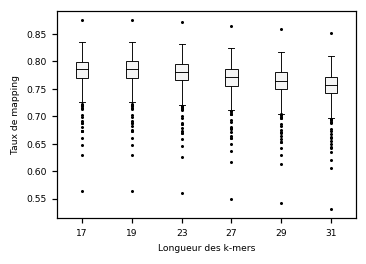

In [263]:
plt.subplots(figsize = (3.5,2.5))
# plt.boxplot(mapping_rates, labels=kmers)
plt.boxplot(mapping_rates, labels=kmers, widths = 0.25, patch_artist = True,\
                 boxprops={'facecolor': 'whitesmoke', 'color' : 'black', 'linewidth': 0.6},\
                 whiskerprops = {'linewidth': 0.6, 'color':'black'},\
                 capprops = {'linewidth': 0.6, 'color':'black'},\
                 medianprops = {'color' : 'black', 'linewidth' : 0.6},\
                 flierprops = {'marker':'.', 'markersize':2,'markerfacecolor':'black', 'markeredgecolor':'black'})
plt.xlabel("Longueur des k-mers")
plt.ylabel("Taux de mapping");
plt.savefig("./figs/kmers.pdf")

### Decoys vs no decoys

In [303]:
quant_params_nodecoys = "trimmed-reads-cutadapt-all/no-decoys-k31-1.4.0/forceCells-3000"
quant_params_decoys = "trimmed-reads-cutadapt-all/decoys-k31-1.4.0/forceCells-3000"

In [304]:
sc_nodecoys = rnaseq.readwrite.read_raw(project_id  = project, quant_tool = "alevin", samples = "all", genes_id = "ensembl_gene_id", quant_params = quant_params_nodecoys, genref = genref, cdna = "3' tag", exp = "sc")
sc_decoys = rnaseq.readwrite.read_raw(project_id  = project, quant_tool = "alevin", samples = "all", genes_id = "ensembl_gene_id", quant_params = quant_params_decoys, genref = genref, cdna = "3' tag", exp = "sc")

/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779/quant/alevin/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/trimmed-reads-cutadapt-all/no-decoys-k31-1.4.0/forceCells-3000
Using BioMart Ensembl Genes 100 hsapiens_gene_ensembl for gene annotations.
/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779/quant/alevin/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/trimmed-reads-cutadapt-all/decoys-k31-1.4.0/forceCells-3000
Using BioMart Ensembl Genes 100 hsapiens_gene_ensembl for gene annotations.


In [298]:
# for s in np.unique(sc_nodecoys.obs["samples"]) :
#     i = np.argsort(sc_nodecoys.obs["raw_cb_freq"].values)[::-1]
#     j = sc_nodecoys.obs["samples"] == s
#     i1 = i[j][:100]
#     i2 = i[~j]
#     sc_nodecoys._inplace_subset_obs(np.concatenate([i1,i2]))

In [299]:
# for s in np.unique(sc_decoys.obs["samples"]) :
#     i = np.argsort(sc_decoys.obs["raw_cb_freq"].values)[::-1]
#     j = sc_decoys.obs["samples"] == s
#     i1 = i[j][:100]
#     i2 = i[~j]
#     sc_decoys._inplace_subset_obs(np.concatenate([i1,i2]))

In [305]:
ps_nodecoys = rnaseq.utils.pseudobulk(sc_nodecoys, group_by_annot_name="samples")
ps_decoys = rnaseq.utils.pseudobulk(sc_decoys, group_by_annot_name="samples")

/u/davidm/VirtualEns/python_3.9.5/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Using BioMart Ensembl Genes 100 hsapiens_gene_ensembl for gene annotations.
Using BioMart Ensembl Genes 100 hsapiens_gene_ensembl for gene annotations.


In [306]:
bulk_salmon_decoys = rnaseq.readwrite.read_raw(project_id  = "dsp356", quant_tool = "salmon", samples = "all", genes_id = "ensembl_gene_id", quant_params = "raw-reads/decoys-k31-1.4.0", genref = genref, layer = "norm", cdna = "full length", exp = "bulk", shuffle_samples=False)
rnaseq.setup.annotate_genes(bulk_salmon_decoys, genes_annot_name = "exonic_length", compute_length = {"start" : "exon_chrom_start", "stop" : "exon_chrom_end"}, save_path = annot_path + "/biomart_ens100")

bulk_salmon_nodecoys = rnaseq.readwrite.read_raw(project_id  = "dsp356", quant_tool = "salmon", samples = "all", genes_id = "ensembl_gene_id", quant_params = "raw-reads/no-decoys-k31-1.4.0", genref = genref, cdna = "full length", layer = "norm", exp = "bulk", shuffle_samples=False)
rnaseq.setup.annotate_genes(bulk_salmon_nodecoys, genes_annot_name = "exonic_length", compute_length = {"start" : "exon_chrom_start", "stop" : "exon_chrom_end"}, save_path = annot_path + "/biomart_ens100")

/home/arion/davidm/Data/datasets/raw/private/RNA-seq/bulk/dsp356/quant/salmon/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/raw-reads/decoys-k31-1.4.0
Using BioMart Ensembl Genes 100 hsapiens_gene_ensembl for gene annotations.
Annotating exonic_length using /home/arion/davidm/Data/references/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/biomart_ens100/ensembl_gene_id-to-exonic_length.csv...
/home/arion/davidm/Data/datasets/raw/private/RNA-seq/bulk/dsp356/quant/salmon/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/raw-reads/no-decoys-k31-1.4.0
Using BioMart Ensembl Genes 100 hsapiens_gene_ensembl for gene annotations.
Annotating exonic_length using /home/arion/davidm/Data/references/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/biomart_ens100/ensembl_gene_id-to-exonic_length.csv...


In [180]:
rnaseq.setup.annotate_genes(bulk_salmon_decoys)
rnaseq.setup.annotate_genes(bulk_salmon_decoys,"gene_biotype")
# bulk_salmon_decoys._inplace_subset_var(bulk_salmon_decoys.var["gene_biotype"]=="protein_coding")

Annotating external_gene_name using Biomart (Ensembl Genes 100, 'hsapiens_gene_ensembl')...
gene_biotype already annotated. Set ow = True if you want to overwrite.


Normalization by total UMIs...
This is CPM normalization.
Log2 + 1 tranformation...


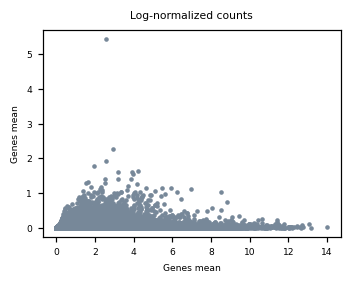

Normalization by total UMIs...
This is CPM normalization.
Log2 + 1 tranformation...


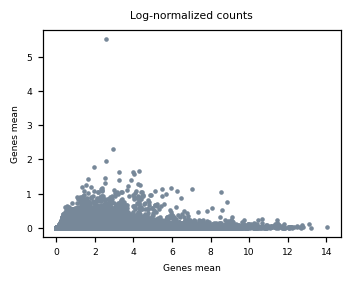

Dataset already log-normalized.


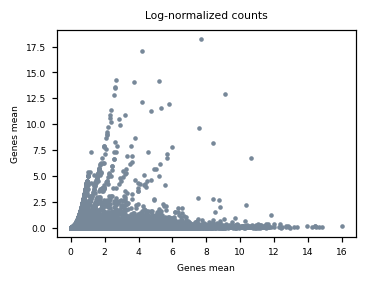

Dataset already log-normalized.


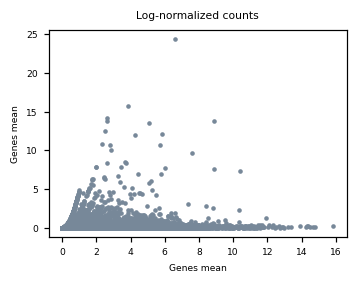

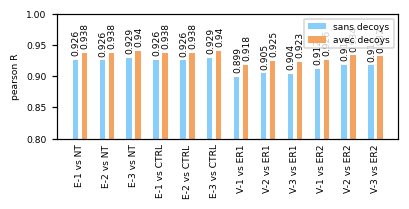

In [310]:
rnaseq.utils.match_genes([bulk_salmon_decoys, bulk_salmon_nodecoys, ps_nodecoys, ps_decoys])

rnaseq.pp.log_norm(ps_nodecoys, tot=1e6, plot=True, log=True, ow = True)
rnaseq.pp.log_norm(ps_decoys, tot=1e6, plot=True, log=True, ow = True)
rnaseq.pp.log_norm(bulk_salmon_nodecoys, tot=1e6, log=True, plot=True)
rnaseq.pp.log_norm(bulk_salmon_decoys, tot=1e6, log=True, plot=True)

# psnd = ps_nodecoys.X.toarray().ravel()
# psd = ps_decoys.X.toarray().ravel()

fig,ax = plt.subplots(figsize = (4,1.5))
i=0
labels = []
i_bulk = [o in ['Sample_E-1', 'Sample_E-2','Sample_E-3'] for o in bulk_salmon_nodecoys.obs["samples"]]
for bnd, bd, rep in zip(bulk_salmon_nodecoys.X.toarray()[i_bulk], bulk_salmon_decoys.X.toarray()[i_bulk], ['E-1', 'E-2','E-3']):
        sample = "NT"
#         bd = np.log2(1 + bd)
#         bnd = np.log2(1 + bnd)
        psd = ps_decoys.X.toarray()[ps_decoys.obs["samples"]=="Sample_N701_-_Not_Transfected"][0]
#         psd = np.log2(1 + psd)
        psnd = ps_nodecoys.X.toarray()[ps_nodecoys.obs["samples"]=="Sample_N701_-_Not_Transfected"][0]
#         psnd = np.log2(1 + psnd)
        
        ax.bar(i, stats.pearsonr(bnd, psnd)[0], color = "lightskyblue", width = 0.6, label = "sans decoys" if i == 0 else "")
        ax.text(s=round(stats.pearsonr(bnd, psnd)[0], 3), x=i-0.4, y=stats.pearsonr(bnd, psnd)[0]+1e-2, rotation=90)
        ax.bar(i+1, stats.pearsonr(bd, psd)[0], color = "sandybrown", width = 0.6, label = "avec decoys" if i == 0 else "")
        ax.text(s=round(stats.pearsonr(bd, psd)[0], 3), x=i+0.6, y=stats.pearsonr(bd, psd)[0]+1e-2, rotation=90)
        labels.append(f"{rep} vs {sample}")
        i+=3

i_bulk = [o in ['Sample_E-1', 'Sample_E-2','Sample_E-3'] for o in bulk_salmon_nodecoys.obs["samples"]]
for bnd, bd, rep in zip(bulk_salmon_nodecoys.X.toarray()[i_bulk], bulk_salmon_decoys.X.toarray()[i_bulk], ['E-1', 'E-2','E-3']):
        sample = "CTRL"
#         bd = np.log2(1 + bd)
#         bnd = np.log2(1 + bnd)
        psd = ps_decoys.X.toarray()[ps_decoys.obs["samples"]=="Sample_N701_-_Not_Transfected"][0]
#         psd = np.log2(1 + psd)
        psnd = ps_nodecoys.X.toarray()[ps_nodecoys.obs["samples"]=="Sample_N701_-_Not_Transfected"][0]
#         psnd = np.log2(1 + psnd)
        
        ax.bar(i, stats.pearsonr(bnd, psnd)[0], color = "lightskyblue", width = 0.6, label = "sans decoys" if i == 0 else "")
        ax.text(s=round(stats.pearsonr(bnd, psnd)[0], 3), x=i-0.4, y=stats.pearsonr(bnd, psnd)[0]+1e-2, rotation=90)
        ax.bar(i+1, stats.pearsonr(bd, psd)[0], color = "sandybrown", width = 0.6, label = "avec decoys" if i == 0 else "")
        ax.text(s=round(stats.pearsonr(bd, psd)[0], 3), x=i+0.6, y=stats.pearsonr(bd, psd)[0]+1e-2, rotation=90)
        labels.append(f"{rep} vs {sample}")
        i+=3

        
i_bulk = [o in ['Sample_V-1', 'Sample_V-2','Sample_V-3'] for o in bulk_salmon_nodecoys.obs["samples"]]
for bnd, bd, rep in zip(bulk_salmon_nodecoys.X.toarray()[i_bulk], bulk_salmon_decoys.X.toarray()[i_bulk], ['V-1', 'V-2','V-3']):
        sample = "ER1"
#         bd = np.log2(1 + bd)
#         bnd = np.log2(1 + bnd)
        psd = ps_decoys.X.toarray()[ps_decoys.obs["samples"]=="Sample_N705_-_ER1"][0]
#         psd = np.log2(1 + psd)
        psnd = ps_nodecoys.X.toarray()[ps_nodecoys.obs["samples"]=="Sample_N705_-_ER1"][0]
#         psnd = np.log2(1 + psnd)
        ax.bar(i, stats.pearsonr(bnd, psnd)[0], color = "lightskyblue", width = 0.6, label = "sans decoys" if i == 0 else "")
        ax.text(s=round(stats.pearsonr(bnd, psnd)[0], 3), x=i-0.4, y=stats.pearsonr(bnd, psnd)[0]+1e-2, rotation=90)
        ax.bar(i+1, stats.pearsonr(bd, psd)[0], color = "sandybrown", width = 0.6, label = "avec decoys" if i == 0 else "")
        ax.text(s=round(stats.pearsonr(bd, psd)[0], 3), x=i+0.6, y=stats.pearsonr(bd, psd)[0]+1e-2, rotation=90)
        labels.append(f"{rep} vs {sample}")
        i+=3
        
i_bulk = [o in ['Sample_V-1', 'Sample_V-2','Sample_V-3'] for o in bulk_salmon_nodecoys.obs["samples"]]
for bnd, bd, rep in zip(bulk_salmon_nodecoys.X.toarray()[i_bulk], bulk_salmon_decoys.X.toarray()[i_bulk], ['V-1', 'V-2','V-3']):
        sample = "ER2"
#         bd = np.log2(1 + bd)
#         bnd = np.log2(1 + bnd)
        psd = ps_decoys.X.toarray()[ps_decoys.obs["samples"]=="Sample_N707_-_ER2"][0]
#         psd = np.log2(1 + psd)
        psnd = ps_nodecoys.X.toarray()[ps_nodecoys.obs["samples"]=="Sample_N707_-_ER2"][0]
#         psnd = np.log2(1 + psnd)
        ax.bar(i, stats.pearsonr(bnd, psnd)[0], color = "lightskyblue", width = 0.6, label = "sans decoys" if i == 0 else "")
        ax.text(s=round(stats.pearsonr(bnd, psnd)[0], 3), x=i-0.4, y=stats.pearsonr(bnd, psnd)[0]+1e-2, rotation=90)
        ax.bar(i+1, stats.pearsonr(bd, psd)[0], color = "sandybrown", width = 0.6, label = "avec decoys" if i == 0 else "")
        ax.text(s=round(stats.pearsonr(bd, psd)[0], 3), x=i+0.6, y=stats.pearsonr(bd, psd)[0]+1e-2, rotation=90)
        labels.append(f"{rep} vs {sample}")
        i+=3
        
        
ax.set_ylim(0.8,1)
ax.legend()
ax.set_xticks(np.arange(0.5,len(labels)*3,3))
ax.set_xticklabels(labels=labels)
ax.tick_params('x', length = 0, labelrotation = 90)
ax.set_yticks(np.arange(0.8,1.05,0.05))
plt.ylabel("pearson R");

plt.savefig("./figs/decoys_comp.pdf")

In [296]:
np.unique(sc_decoys.obs["samples"])

array(['Sample_N702_-_CTR1', 'Sample_N705_-_ER1', 'Sample_N707_-_ER2'],
      dtype=object)

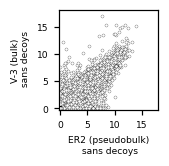

In [255]:
_,ax = plt.subplots(figsize = (1.2,1.2))

ax.scatter(psnd, bnd, s=4, c='white', edgecolors='black', linewidths=0.15)
ax.set_xlabel("ER2 (pseudobulk)\n sans decoys")
ax.set_ylabel("V-3 (bulk)\n sans decoys")
plt.axis('square')
plt.xlim(-0.25,18)
plt.xticks(np.arange(0,18,5))
plt.yticks(np.arange(0,18,5))
plt.ylim(-0.25,18)
plt.savefig("./figs/decoys_scatt_1.pdf");

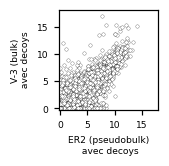

In [256]:
_,ax = plt.subplots(figsize = (1.2,1.2))

ax.scatter(psd, bd, s=5, c='white', edgecolors='black', linewidths=0.15)
ax.set_xlabel("ER2 (pseudobulk)\n avec decoys")
ax.set_ylabel("V-3 (bulk)\n avec decoys")
plt.axis('square')
plt.xlim(-0.25,18)
plt.xticks(np.arange(0,18,5))
plt.yticks(np.arange(0,18,5))
plt.ylim(-0.25,18)
plt.savefig("./figs/decoys_scatt_2.pdf");

In [111]:
# i = bulk_salmon_decoys.obs["samples"] == "Sample_V-2"
# j = bulk_salmon_nodecoys.obs["samples"] == "Sample_V-2"

# bd = np.log2(1 +  bulk_salmon_decoys.X.toarray()[i])
# bnd = np.log2(1 + bulk_salmon_nodecoys.X.toarray()[j])

# bd = bulk_salmon_decoys.X.toarray()[i]
# bnd = bulk_salmon_nodecoys.X.toarray()[j]

In [150]:
np.unique(bulk_salmon_decoys.var["gene_biotype"])

array(['IG_C_gene', 'IG_C_pseudogene', 'IG_D_gene', 'IG_J_gene',
       'IG_J_pseudogene', 'IG_V_gene', 'IG_V_pseudogene', 'IG_pseudogene',
       'Mt_rRNA', 'Mt_tRNA', 'TEC', 'TR_C_gene', 'TR_D_gene', 'TR_J_gene',
       'TR_J_pseudogene', 'TR_V_gene', 'TR_V_pseudogene', 'lncRNA',
       'miRNA', 'misc_RNA', 'polymorphic_pseudogene',
       'processed_pseudogene', 'protein_coding', 'pseudogene', 'rRNA',
       'rRNA_pseudogene', 'ribozyme', 'sRNA', 'scRNA', 'scaRNA', 'snRNA',
       'snoRNA', 'transcribed_processed_pseudogene',
       'transcribed_unitary_pseudogene',
       'transcribed_unprocessed_pseudogene',
       'translated_processed_pseudogene',
       'translated_unprocessed_pseudogene', 'unitary_pseudogene',
       'unprocessed_pseudogene', 'vaultRNA'], dtype=object)

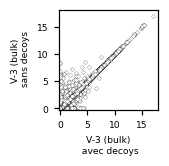

In [257]:
_,ax = plt.subplots(figsize = (1.2,1.2))

i = np.array([s.endswith("pseudogene") for s in bulk_salmon_decoys.var["gene_biotype"]])
# i = np.array([j if j == True else s.startswith("RP") for s,j in zip(bulk_salmon_decoys.var["external_gene_name"],i)])
# i = np.array([s == "NPIPA9" for s in bulk_salmon_decoys.var["external_gene_name"]])

# ax.scatter(bd[i], bnd[i], s=5, c="indianred", edgecolors='black', linewidths=0.15, label = "pseudogène")
# ax.scatter(bd[~i], bnd[~i], s=5, c="white", edgecolors='black', linewidths=0.15, label = "autre")
ax.scatter(bd, bnd, s=5, c="white", edgecolors='black', linewidths=0.15)
ax.set_xlabel("V-3 (bulk)\n avec decoys")
ax.set_ylabel("V-3 (bulk)\n sans decoys")
plt.axis('square')
plt.xlim(-0.25,18)
plt.xticks(np.arange(0,18,5))
plt.yticks(np.arange(0,18,5))
plt.ylim(-0.25,18)
# plt.legend()
plt.savefig("./figs/decoys_scatt_3.pdf");

In [192]:
bulk_salmon_decoys.var[(bd>4.5) & (bnd<4)]

,ensembl_gene_id,exonic_length,gene_biotype,external_gene_name
ENSG00000137970,ENSG00000137970,746,processed_pseudogene,RPL7P9
ENSG00000198744,ENSG00000198744,546,unprocessed_pseudogene,MTCO3P12
ENSG00000233024,ENSG00000233024,5041,protein_coding,NPIPA9
ENSG00000236876,ENSG00000236876,134,processed_pseudogene,TMSB4XP1


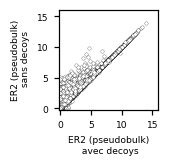

In [258]:
_,ax = plt.subplots(figsize = (1.2,1.2))

ax.scatter(psd, psnd, s=5, c='white', edgecolors='black', linewidths=0.15)
ax.set_xlabel("ER2 (pseudobulk)\n avec decoys")
ax.set_ylabel("ER2 (pseudobulk)\n sans decoys")
plt.axis('square')
plt.xlim(-0.25,16)
plt.xticks(np.arange(0,16,5))
plt.yticks(np.arange(0,16,5))
plt.ylim(-0.25,16)
plt.savefig("./figs/decoys_scatt_4.pdf");

### Abberrant expression (e.g. in sc but not in bulk)

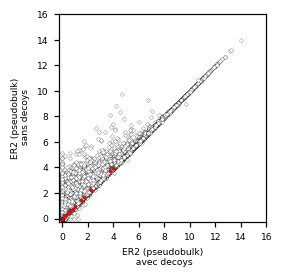

In [138]:
_,ax = plt.subplots(figsize = (2.5,2.5))

ax.scatter(psd[[gps not in g for gps in ps_decoys.var_names]], psnd[[gps not in g for gps in ps_decoys.var_names]], s=5, c='white', edgecolors='black', linewidths=0.15)
ax.scatter(psd[[gps in g for gps in ps_decoys.var_names]], psnd[[gps in g for gps in ps_decoys.var_names]], s=5, c='red', edgecolors='black', linewidths=0.15)
ax.set_xlabel("ER2 (pseudobulk)\n avec decoys")
ax.set_ylabel("ER2 (pseudobulk)\n sans decoys")
plt.axis('square')
plt.xlim(-0.25,16)
plt.xticks(np.arange(0,17,2))
plt.ylim(-0.25,16)
plt.savefig("./figs/decoys_scatt_4.pdf");

In [313]:
rnaseq.setup.annotate_genes(ps_decoys)

Annotating external_gene_name using Biomart (Ensembl Genes 100, 'hsapiens_gene_ensembl')...


In [345]:
rnaseq.setup.annotate_genes(ps_decoys, "gene_biotype")

Annotating gene_biotype using Biomart (Ensembl Genes 100, 'hsapiens_gene_ensembl')...


In [334]:
rnaseq.utils.match_genes([bulk_star, ps_decoys])

In [333]:
m = pd.read_table("/home/arion/davidm/Data/datasets/raw/private/RNA-seq/bulk/old/bulk-MCF7_DSP356/quant/star/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/raw-reads/E/E-1/rsem.genes.results")
genes = np.array([g.split(".")[0] for g in m["gene_id"]])
bulk_star = AnnData(X = np.log2(m["TPM"].values + 1).reshape(1,-1), var = pd.DataFrame(genes, index = genes, columns=["ensembl_gene_id"]))

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [349]:
psd = ps_decoys.X.toarray()[2]
bd = bulk_star.X[0]

In [133]:
g = bulk_salmon_decoys.var_names[(bd > 2) & (bnd == 0)]

In [132]:
bulk_salmon_decoys.var["external_gene_name"][(bd > 2) & (bnd == 0)]

ENSG00000178458         H3P16
ENSG00000198618       PPIAP22
ENSG00000199415     RNA5SP370
ENSG00000199480     RNA5SP389
ENSG00000201185     RNA5SP202
ENSG00000212802       RPL15P3
ENSG00000230629       RPS23P8
ENSG00000231414    AC016700.1
ENSG00000233870    AC007881.1
ENSG00000235912    AL031729.1
ENSG00000236876      TMSB4XP1
ENSG00000256843    AC023157.1
ENSG00000280466       SCARNA4
ENSG00000282416    AC092299.1
Name: external_gene_name, dtype: object

In [352]:
ps_decoys.var["external_gene_name"][(bd > 4) & (psd == 0)]

ENSG00000068308         OTUD5
ENSG00000076924          XAB2
ENSG00000085998       POMGNT1
ENSG00000090971         NAT14
ENSG00000095397          WHRN
ENSG00000099364        FBXL19
ENSG00000099822          HCN2
ENSG00000100890         PRORP
ENSG00000105321         CCDC9
ENSG00000105426         PTPRS
ENSG00000108819       PPP1R9B
ENSG00000126062       TMEM115
ENSG00000135046         ANXA1
ENSG00000141854         MISP3
ENSG00000144785    AC073896.1
ENSG00000158773          USF1
ENSG00000158792       SPATA2L
ENSG00000160685        ZBTB7B
ENSG00000161036         LRWD1
ENSG00000162004        CCDC78
ENSG00000163485        ADORA1
ENSG00000163702        IL17RC
ENSG00000170604       IRF2BP1
ENSG00000173227         SYT12
ENSG00000181222        POLR2A
ENSG00000183401       CCDC159
ENSG00000187720         THSD4
ENSG00000198467          TPM2
ENSG00000198551        ZNF627
ENSG00000267059    AC005943.1
ENSG00000268790    AC008764.4
ENSG00000272921    AC005832.4
ENSG00000283149    AC068631.3
ENSG000002

In [322]:
ps_decoys.var["external_gene_name"][(bd > 4) & (psd == 0)]

ENSG00000005884         ITGA3
ENSG00000008382          MPND
ENSG00000008710          PKD1
ENSG00000071282         LMCD1
ENSG00000077238          IL4R
ENSG00000083857          FAT1
ENSG00000087152       ATXN7L3
ENSG00000099364        FBXL19
ENSG00000102878          HSF4
ENSG00000104897         SF3A2
ENSG00000105321         CCDC9
ENSG00000105426         PTPRS
ENSG00000105655        ISYNA1
ENSG00000107263       RAPGEF1
ENSG00000115419           GLS
ENSG00000115657         ABCB6
ENSG00000120253         NUP43
ENSG00000123143          PKN1
ENSG00000127415          IDUA
ENSG00000132017        DCAF15
ENSG00000136379       ABHD17C
ENSG00000140479         PCSK6
ENSG00000142733        MAP3K6
ENSG00000144785    AC073896.1
ENSG00000147883        CDKN2B
ENSG00000149591         TAGLN
ENSG00000160271        RALGDS
ENSG00000160685        ZBTB7B
ENSG00000161956         SENP3
ENSG00000162004        CCDC78
ENSG00000163517        HDAC11
ENSG00000164576        SAP30L
ENSG00000167548         KMT2D
ENSG000001

In [320]:
ps_decoys.var["external_gene_name"][(bd > 4) & (psd == 0)]

ENSG00000005884         ITGA3
ENSG00000007944         MYLIP
ENSG00000008382          MPND
ENSG00000008710          PKD1
ENSG00000061273         HDAC7
                      ...    
ENSG00000270757    HSPE1-MOB4
ENSG00000272921    AC005832.4
ENSG00000283149    AC068631.3
ENSG00000285723    AL034430.2
ENSG00000286070          GGT1
Name: external_gene_name, Length: 66, dtype: object

In [314]:
ps_decoys.var["external_gene_name"][(bd > 4) & (psd == 0)]

ENSG00000132016      C19orf57
ENSG00000161956         SENP3
ENSG00000162004        CCDC78
ENSG00000176248        ANAPC2
ENSG00000198467          TPM2
ENSG00000255072          PIGY
ENSG00000270757    HSPE1-MOB4
ENSG00000272921    AC005832.4
ENSG00000284981       UPK3BL2
Name: external_gene_name, dtype: object

In [323]:
ps_decoys.var["external_gene_name"][(psd > 4) & (bd == 0)]

ENSG00000161939    RNASEK-C17orf49
ENSG00000198211         AC092143.1
ENSG00000235272             RAMACL
ENSG00000236444             UBE2L5
ENSG00000248167       TRIM39-RPP21
ENSG00000251357         AP000350.4
ENSG00000254692         AL136295.1
ENSG00000254870    ATP6V1G2-DDX39B
ENSG00000255730         AC011462.1
ENSG00000256861         AC048338.1
ENSG00000257524         AL157935.3
ENSG00000257921         AC025165.3
ENSG00000260272         AC093525.2
ENSG00000262526         AC120057.2
ENSG00000269711         AC008763.3
ENSG00000270617       URGCP-MRPS24
ENSG00000273003         ARL2-SNX15
ENSG00000276612         FP565260.2
ENSG00000284491              THSD8
ENSG00000284934         AC048338.2
ENSG00000285238         AC006064.6
ENSG00000285330         AC126283.2
ENSG00000285526         AC020907.6
ENSG00000285645         AL133410.3
ENSG00000285762         AC253536.7
ENSG00000285901         AC008012.1
ENSG00000285920         AC087721.2
ENSG00000286264         AP001453.5
Name: external_gene_

In [319]:
ps_decoys.var["external_gene_name"][(psd > 4) & (bd == 0)]

ENSG00000198211      AC092143.1
ENSG00000235272          RAMACL
ENSG00000248167    TRIM39-RPP21
ENSG00000251357      AP000350.4
ENSG00000255730      AC011462.1
ENSG00000260272      AC093525.2
ENSG00000262526      AC120057.2
ENSG00000268173      AC007192.1
ENSG00000269711      AC008763.3
ENSG00000270617    URGCP-MRPS24
ENSG00000273003      ARL2-SNX15
ENSG00000273590         SMIM11B
ENSG00000276612      FP565260.2
ENSG00000284491           THSD8
ENSG00000284934      AC048338.2
ENSG00000285330      AC126283.2
ENSG00000285526      AC020907.6
ENSG00000285645      AL133410.3
ENSG00000285762      AC253536.7
ENSG00000285839      AL445685.3
ENSG00000285901      AC008012.1
Name: external_gene_name, dtype: object

In [317]:
ps_decoys.var["external_gene_name"][(psd > 4) & (bd == 0)]

ENSG00000156413              FUT6
ENSG00000235272            RAMACL
ENSG00000248167      TRIM39-RPP21
ENSG00000251357        AP000350.4
ENSG00000255730        AC011462.1
ENSG00000256618          MTRNR2L1
ENSG00000260272        AC093525.2
ENSG00000262526        AC120057.2
ENSG00000268173        AC007192.1
ENSG00000269711        AC008763.3
ENSG00000270617      URGCP-MRPS24
ENSG00000273590           SMIM11B
ENSG00000276612        FP565260.2
ENSG00000278139    P3R3URF-PIK3R3
ENSG00000284491             THSD8
ENSG00000284934        AC048338.2
ENSG00000284969        AL049629.2
ENSG00000285330        AC126283.2
ENSG00000285526        AC020907.6
ENSG00000285645        AL133410.3
ENSG00000285762        AC253536.7
Name: external_gene_name, dtype: object

### Multimapping

In [223]:
def read_quants_bin(base_location, clipped=False, mtype="data"):
    '''
    Read the quants Sparse Binary output of Alevin and generates a dataframe
    Parameters
    ----------
    base_location: string
        Path to the folder containing the output of the alevin run
    clipped: bool (default False)
        Clip off all zero rows and columns
    mtype: "[data(default), tier, var, mean]"
        Alevin's matrix type to load into memory
    '''
    if not os.path.isdir(base_location):
        print("{} is not a directory".format( base_location ))
        sys.exit(1)

    base_location = os.path.join(base_location, "alevin")
    
    print(base_location)
    if not os.path.exists(base_location):
        print("{} directory doesn't exist".format( base_location ))
        sys.exit(1)

    data_type = "f"
    if mtype == "data":
        quant_file = os.path.join(base_location, "quants_mat.gz")
    elif mtype == "tier":
        data_type = "B"
        quant_file = os.path.join(base_location, "quants_tier_mat.gz")
    elif mtype == "mean":
        quant_file = os.path.join(base_location, "quants_mean_mat.gz")
    elif mtype == "var":
        quant_file = os.path.join(base_location, "quants_var_mat.gz")
    else:
        print("wrong mtype:".format( mtype ))
        sys.exit(1)

    if not os.path.exists(quant_file):
        print("quant file {} doesn't exist".format( quant_file ))
        sys.exit(1)

    if mtype in ["mean", "var"]:
        cb_file = os.path.join(base_location, "quants_boot_rows.txt")
    else:
        cb_file = os.path.join(base_location, "quants_mat_rows.txt")

    if not os.path.exists(cb_file):
        print("quant file's index: {} doesn't exist".format( cb_file ))
        sys.exit(1)

    gene_file = os.path.join(base_location, "quants_mat_cols.txt")
    
    if not os.path.exists(gene_file):
        print("quant file's header: {} doesn't exist".format(gene_file))
        sys.exit(1)

    cb_names = pd.read_csv(cb_file, header=None)[0].values
    gene_names = pd.read_csv(gene_file, header=None)[0].values
    num_genes = len(gene_names)
    num_cbs = len(cb_names)
    num_entries = int(np.ceil(num_genes/8))

    with gzip.open( quant_file ) as f:
        line_count = 0
        tot_umi_count = 0
        umi_matrix = []

        header_struct = Struct( "B" * num_entries)
        while True:
            line_count += 1
            if line_count%100 == 0:
                print ("\r Done reading " + str(line_count) + " cells", end= "")
                sys.stdout.flush()
            try:
                num_exp_genes = 0
                exp_counts = header_struct.unpack_from( f.read(header_struct.size) )
                for exp_count in exp_counts:
                    num_exp_genes += bin(exp_count).count("1")

                data_struct = Struct( data_type * num_exp_genes)
                sparse_cell_counts_vec = list(data_struct.unpack_from( f.read(data_struct.size) ))[::-1]
                cell_umi_counts = sum(sparse_cell_counts_vec)

            except:
                print ("\nRead total " + str(line_count-1) + " cells")
                print ("Found total " + str(tot_umi_count) + " reads")
                break

            if cell_umi_counts > 0.0:
                tot_umi_count += cell_umi_counts

                cell_counts_vec = []
                for exp_count in exp_counts:
                    for bit in format(exp_count, '08b'):
                        if len(cell_counts_vec) >= num_genes:
                            break

                        if bit == '0':
                            cell_counts_vec.append(0.0)
                        else:
                            abund = sparse_cell_counts_vec.pop()
                            cell_counts_vec.append(abund)

                if len(sparse_cell_counts_vec) > 0:
                    print("Failure in consumption of data")
                    print("left with {} entry(ies)".format(len(sparse_cell_counts_vec)))
                umi_matrix.append( cell_counts_vec )
            else:
                print("Found a CB with no read count, something is wrong")
                sys.exit(1)


    alv = pd.DataFrame(umi_matrix)
    alv.columns = gene_names
    alv.index = cb_names
    if clipped:
        alv = alv.loc[:, (alv != 0).any(axis=0)]

    return alv

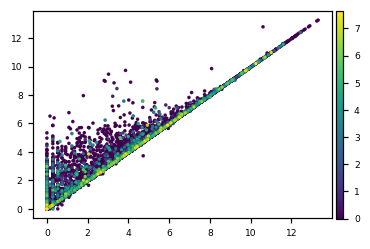

In [256]:
# _,ax = plt.subplots(figsize = (2.5,2.5))

# ax.scatter(psd, psnd, s=5, edgecolors='black', linewidths=0.05, c = (tier==1).sum(0))
rnaseq.plotting.scatter(psd, psnd, s = 5, color = np.log1p((tier == 3).sum(0).values), order_color="ascending",linewidth=0.05);
# ax.set_xlabel("ER2 (pseudobulk)\n avec decoys")
# ax.set_ylabel("ER2 (pseudobulk)\n sans decoys")
# plt.axis('square')
# plt.xlim(-0.25,16)
# plt.xticks(np.arange(0,17,2))
# plt.ylim(-0.25,16)
# plt.savefig("./figs/decoys_scatt_4.pdf");

In [241]:
import os
from struct import Struct

tier = read_quants_bin("/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779/quant/alevin/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/trimmed-reads-cutadapt/pc-no-decoys-k31-1.4.0/forceCells-3000-noWh/Sample_N707_-_ER2", mtype="tier")
mmreads = (tier == 3).sum(0).values

/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779/quant/alevin/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/trimmed-reads-cutadapt/pc-no-decoys-k31-1.4.0/forceCells-3000-noWh/Sample_N707_-_ER2/alevin
 Done reading 3900 cells
Read total 3997 cells
Found total 3486140 reads
